# Solving the n-Queens Problem using Local Search

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum.

## Helper functions

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from numba import njit

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""

    return(np.random.randint(0,n, size = n))


# with jit (cannot use some Python functions like sum and map)
@njit()
def comb2_jit(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

@njit()
def conflicts_jit(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)

    cnt = [0] * (5 * n)

    for i in range(n):
        cnt[board[i]] += 1
        cnt[(n) + (i + board[i])] += 1
        cnt[(3 * n) + (i - board[i] + n)] += 1

    conflicts = 0
    for x in cnt:
        conflicts += comb2_jit(x)

    return conflicts

# decrease the font size to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):
    """display the board"""

    n = len(board)

    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0):
                display[i,j] = 1

    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap,
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])

    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize,
                 horizontalalignment = 'center',
                 verticalalignment = 'center')

    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 2 conflicts.


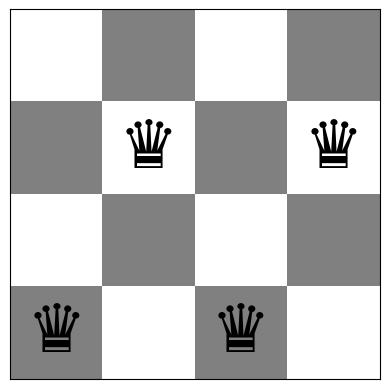

Queens (left to right) are at rows: [3 1 3 1]
Number of conflicts: 2


In [108]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


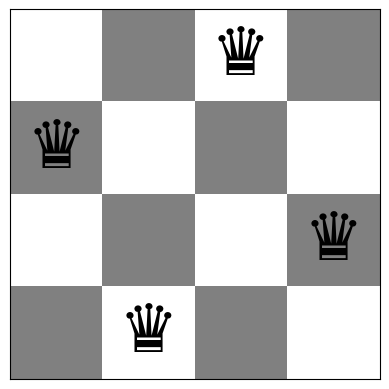

In [109]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [30 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum.

Board with 4 conflicts.


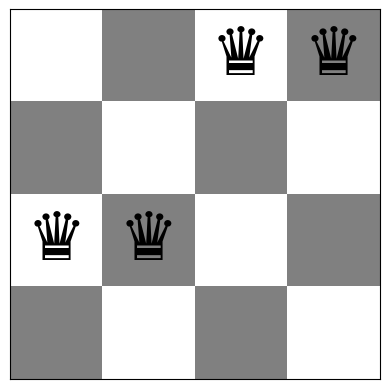

Queens (left to right) are at rows: [2 2 0 0]
Number of conflicts: 4
Local Optimum Met After 1000 tries for a better solution
Board with 1 conflicts.


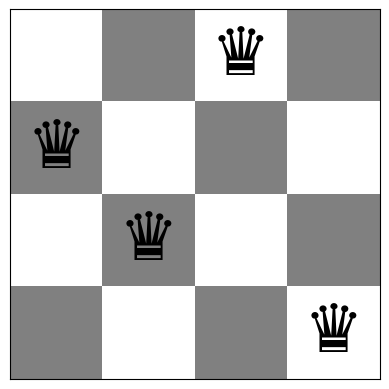

In [135]:
# Code and description go here


def best_successor(board):
  length = len(board)
  best_result = board
  for i in range(length):
    for j in range(length):
      if j != board[i]:
        new_board = list(board)
        new_board[i] = j
        if conflicts_jit(new_board) < conflicts_jit(best_result):
          best_result = new_board
  return best_result

def detect_cycles(board):
  if tuple(board) in visited_states:
    return True
  else:
    visited_states.append(tuple(board))
    return False

def hill_climbing(board):
  visited_states = []
  counter = 0
  conflicts_count = conflicts_jit(board)
  while conflicts_jit(board)>0:
    upd_board = best_successor(board)
    if conflicts_jit(upd_board) >= conflicts_count:
      return board
    board = upd_board
    if detect_cycles(board): counter+=1
    if counter > 1000:
      print("Local Optimum Met After 1000 tries for a better solution")
      break
  return board
board = random_board(4)
show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts_jit(board)}")
show_board(hill_climbing(board))

## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [ ]:
# Code and description go here

## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [ ]:
# Code and description go here

## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.

In [ ]:
# Code and description go here

## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Compare the performance with the previous algorithms.
2. Discuss your choice of annealing schedule.

In [ ]:
# Code and description go here

## Task 6: Compare Performance [10 Points]

Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.

Complete the following table

| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    |     4      |               |                                   |   |
| Stochastic HC 1     |     4      |               |                                   |   |
| Stochastic HC 2     |     4      |               |                                   |   |
| Simulated Annealing |     4      |               |                                   |   |
| Steepest asc. HC    |     8      |               |                                   |   |
| Stochastic HC 1     |     8      |               |                                   |   |
| Stochastic HC 2     |     8      |               |                                   |   |
| Simulated Annealing |     8      |               |                                   |   |


Add the used code and the answer to the following questions below.

* How do the algorithms scale with problem size? You will need to run more board sizes. You can add the results to the table above and show the result as a chart.

* What is the largest board each algorithm can solve in a reasonable amount time?

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

In [ ]:
# Code, results, charts and discussion go here

## Advanced task: Exploring other Local Moves

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

Implement a few different local moves. Implement:

* moving one queen only one square at a time
* switching two columns
* move two queens at a time

Compare the performance of these moves for the 8-Queens problem using your stochastic hill climbing 2 implementation from above. Also consider mixing the use of several types of local moves (e.g., move one queen and moving two queens).

Describe what you find out about how well these moves and combinations of these moves work.

In [ ]:
# Code and description go here

## More Things to Do (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Implement a Genetic Algorithm for the n-Queens problem

In [ ]:
# Code and description go here